In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


In [2]:
#read preprocessed data
df = pd.read_csv(r'2_preprocessed_data.csv')

In [3]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,id_original_df,dialect,id_retrieved_df,text,preprocessed_text
0,0,0,1175358310087892992,IQ,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,لكن بالنهاية ينتفض يغير
1,1,1,1175416117793349632,IQ,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,يعني هذا محسوب على البشر حيونه ووحشيه وتطلبون ...
2,2,2,1175450108898565888,IQ,1175450108898565888,@KanaanRema مبين من كلامه خليجي,مبين من كلامه خليجي
3,3,3,1175471073770573824,IQ,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,يسلملي مرورك وروحك الحلوه
4,4,4,1175496913145217024,IQ,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,وين هل الغيبه اخ محمد
5,5,5,1175668034146643968,IQ,1175668034146643968,@Badi9595 @KanaanRema يااخي الإرهابي اذا كان ع...,يااخي الإرهابي اذا كان عراقي سعودي فلسطيني وين...
6,6,6,1175670153884983296,IQ,1175670153884983296,@SarahNadhum90 @nUBNTdfVgACYQxV مطلبي يقدم است...,مطلبي يقدم استقالته وفوگاها اعتذار
7,7,7,1175671762580856832,IQ,1175671762580856832,@KanaanRema @Badi9595 خلص والله لعيونكم انا ما...,خلص والله لعيونكم انا ماعندي شيء معه بالعكس من...
8,8,8,1175715664398561280,IQ,1175715664398561280,@SalahAlarbawi يمكن سؤال فات الكثير اللي يصور ...,يمكن سؤال فات الكثير اللي يصور شنو موقفه وكأنه...
9,9,9,1176019816072777728,IQ,1176019816072777728,@Eng_alow91 @cb4LwpWrS1hT5lb @EdyCohen اولا ان...,اولا اني ردت على رجل جنوبي واللي ذكر حجابها ثا...


In [4]:
#an example of the old and preprocessed texts
i = 6
print(df['text'][i])
print(df['preprocessed_text'][i])

@SarahNadhum90 @nUBNTdfVgACYQxV مطلبي يقدم استقالته وفوگاها اعتذار
مطلبي يقدم استقالته وفوگاها اعتذار


In [5]:
# now we will choose the columns which we will use
final_df = df[['preprocessed_text', 'dialect']]

In [6]:
final_df.shape

(453232, 2)

In [7]:
final_df.isnull().sum()

preprocessed_text    0
dialect              0
dtype: int64

In [8]:
final_df.head()

,preprocessed_text,dialect
0,لكن بالنهاية ينتفض يغير,IQ
1,يعني هذا محسوب على البشر حيونه ووحشيه وتطلبون ...,IQ
2,مبين من كلامه خليجي,IQ
3,يسلملي مرورك وروحك الحلوه,IQ
4,وين هل الغيبه اخ محمد,IQ


<AxesSubplot:xlabel='count', ylabel='dialect'>

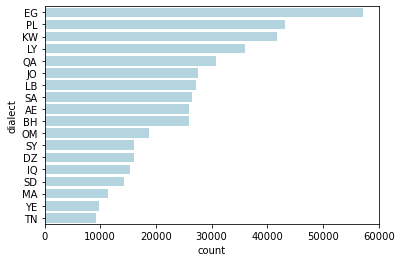

In [9]:
#now let's see the count of each class
sns.countplot(data = final_df, y = 'dialect', order=final_df.dialect.value_counts().index, color = 'lightblue')


In [11]:
# here i tried to solve the imbalancing problem by limiting all class to the number of the lowest class
lowest = final_df[final_df.dialect == 'TN'].iloc[:9149]

for i in final_df.dialect.unique():
    temp = final_df[final_df.dialect == i].iloc[:9149]
    final = pd.concat([lowest, temp])
    lowest = final

In [12]:
final = final.drop_duplicates()
final.dialect.value_counts()

TN    9149
MA    9149
AE    9149
KW    9149
LB    9149
IQ    9149
SA    9149
YE    9149
JO    9149
SY    9149
PL    9149
QA    9149
LY    9149
BH    9149
EG    9148
SD    9148
DZ    9147
OM    9147
Name: dialect, dtype: int64

<AxesSubplot:xlabel='count', ylabel='dialect'>

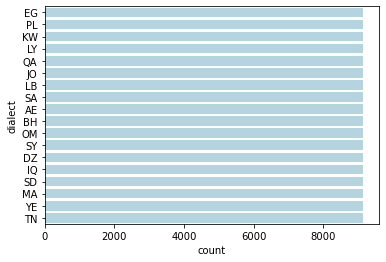

In [13]:
#and this is how it looks
sns.countplot(data = final, y = 'dialect', order=final_df.dialect.value_counts().index, color = 'lightblue')


In [14]:
final.head()

,preprocessed_text,dialect
141490,ناس بكري قالوا طيح وشوف شكون يوقف معاك غيب وشو...,TN
141491,تهبل والله فنانة مبدعة انت ماشاء الله,TN
141492,الله يبارك فيك يعيشك,TN
141493,عيدكم مبروك وسنين دايمة,TN
141494,الله يسلمك دلوع الغالية ويمتعك بالصحة والعافية...,TN


In [15]:
final.shape

(164676, 2)

In [16]:
# spliting the data
from sklearn.model_selection import train_test_split

# x_train, x, y_train, y = train_test_split(final['preprocessed_text'], 
#                                           final['dialect'], test_size=.15, 
#                                           random_state = 60)

x_train, x, y_train, y = train_test_split(final_df['preprocessed_text'], 
                                          final_df['dialect'], test_size=.20, 
                                          random_state = 60)

x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=.5)

x_train.shape, x_test.shape, x_val.shape

((362585,), (45324,), (45323,))

In [17]:
target_encoded = final_df['dialect'].factorize()
target_encoded

(array([ 0,  0,  0, ..., 17, 17, 17], dtype=int64),
 Index(['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ', 'EG',
        'LB', 'KW', 'OM', 'SD', 'AE', 'BH'],
       dtype='object'))

In [18]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
le= label_encoder.fit_transform(final_df['dialect'])

In [19]:
le

array([4, 4, 4, ..., 1, 1, 1])

In [20]:
final_df['encoded'] = le

C:\Users\midom\AppData\Local\Temp/ipykernel_11712/1474298800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['encoded'] = le


In [21]:
final_df.tail(10)

,preprocessed_text,dialect,encoded
453222,انا ااكلك رز باللحمه والله نسيت اسم المنطقه ال...,BH,1
453223,يجون يشوفون اللي عندنا حتى باب السياره له ناس ...,BH,1
453224,مو متعود ع الرومنسية,BH,1
453225,عيونك ما ادري شقول فيا بسخليها خليها,BH,1
453226,اي والله صدق مايعرف يتكلم ويناقش,BH,1
453227,مبسوطين منك اللي باسطانا,BH,1
453228,والله ماينده ابش يختي,BH,1
453229,شو عملنا لك حنا تهربي مننا احنا مساكين ليش بتع...,BH,1
453230,الله يبارك فيها وبالعافيه,BH,1
453231,السحله ضيفي ي بتطلع لك سحليه,BH,1


In [22]:
final_df[final_df['encoded'] == 1]['dialect'].values[0]

'BH'

In [24]:
# calculating every class weight to balancing the data as possible
my_weights = 1 - y_train.value_counts(normalize=True)

my_class_weights = {}
for val, cnt in my_weights.iteritems():
#     print('value', val, 'was found', cnt, 'times')
    my_class_weights[val] = cnt

In [25]:
my_class_weights

{'EG': 0.8737289187362963,
 'PL': 0.9046816608519381,
 'KW': 0.9078009294372354,
 'LY': 0.9206641201373471,
 'QA': 0.9316987740805605,
 'JO': 0.9394155853110305,
 'LB': 0.9398871988637147,
 'SA': 0.9415502571810748,
 'AE': 0.942510032130397,
 'BH': 0.9425872554021816,
 'OM': 0.9586028103754982,
 'DZ': 0.9645269385109698,
 'SY': 0.9646151936787236,
 'IQ': 0.9661624170884069,
 'SD': 0.9685149689038433,
 'MA': 0.9748086655542838,
 'YE': 0.9784933188080036,
 'TN': 0.9797509549484948}

In [26]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# plot_multiclass_roc(clf, x_test, y_test, n_classes=18, figsize=(16, 10))

# SVC with Imbalanced data

In [66]:
from sklearn.svm import LinearSVC

lsvc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(class_weight=my_class_weights))])
                
#                ('svc', SVC(kernel='poly', degree=3, C=1))])
lsvc.fit(x_train, y_train)


y_pred = lsvc.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=target_encoded[1]))

accuracy 0.5488703556614597
              precision    recall  f1-score   support

          IQ       0.42      0.43      0.43      2542
          LY       0.40      0.34      0.37      2607
          QA       0.60      0.55      0.57      1563
          PL       0.72      0.86      0.78      5727
          SY       0.60      0.56      0.58      1501
          TN       0.43      0.36      0.39      2868
          JO       0.50      0.59      0.54      4105
          MA       0.63      0.68      0.66      2756
          SA       0.67      0.68      0.68      3660
          YE       0.74      0.59      0.66      1165
          DZ       0.43      0.37      0.40      1890
          EG       0.50      0.54      0.52      4333
          LB       0.47      0.50      0.49      2995
          KW       0.42      0.44      0.43      2695
          OM       0.68      0.57      0.62      1431
          SD       0.46      0.35      0.40      1604
          AE       0.63      0.48      0.55       874

In [67]:
predict = lsvc.predict(x_train)
print('train score : ', lsvc.score(x_train, y_train))
print('validation score : ', lsvc.score(x_val , y_val))
print('test score : ', lsvc.score(x_test, y_test))

train score :  0.9321703876332447
validation score :  0.5505372548154359
test score :  0.5488703556614597


In [69]:
from sklearn.metrics import f1_score

predict_x = lsvc.predict(x_test)
print("F1 Score = ", f1_score(y_test, predict_x,average='macro'))


F1 Score =  0.5183476217443239


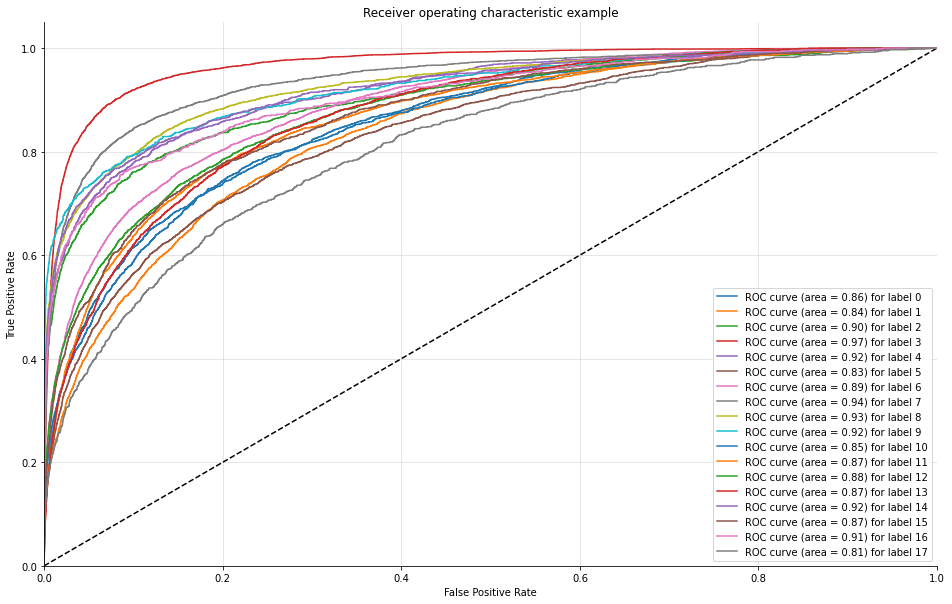

In [29]:
plot_multiclass_roc(lsvc, x_test, y_test, n_classes=18, figsize=(16, 10))

C:\Users\midom\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


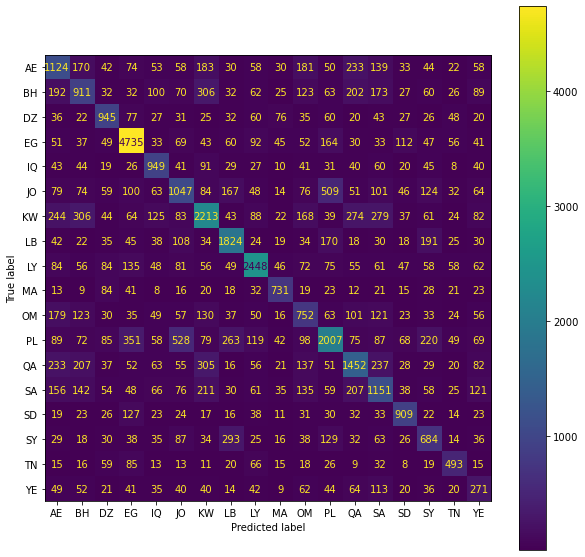

In [30]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(lsvc, x_val, y_val, ax=ax)  


In [79]:
print(lsvc.predict(['ياسطا'])[0])
print(lsvc.predict(['شلونك'])[0] )
print(lsvc.predict(['هلا والله'])[0])
print(lsvc.predict(['بزاف'])[0] )
print(lsvc.predict(['جزائر'])[0])
print(lsvc.predict(['مصر'])[0])

EG
IQ
KW
DZ
DZ
EG


In [31]:
import pickle

# saving
with open(r'C:\Users\midom\OneDrive\Desktop\aim_new\lsvc.pkl', 'wb') as file:
    pickle.dump(lsvc, file, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
pickle.dump(lsvc, open(r'C:\Users\midom\OneDrive\Desktop\aim_new\lsvc_new.pkl', 'wb'))

In [51]:
predict = {'prediction_dl' : 5,'prediction_ml' : 6}

In [60]:
list(predict.keys())[0]

'prediction_dl'

In [61]:
predict['prediction_dl']

5

# SVC with Balanced data

In [70]:
x_train, x, y_train, y = train_test_split(final['preprocessed_text'], 
                                          final['dialect'], test_size=.15, 
                                          random_state = 60)

x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=.5)

x_train.shape, x_test.shape, x_val.shape

((139974,), (12351,), (12351,))

In [71]:
from sklearn.svm import LinearSVC

lsvc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(class_weight=my_class_weights))])
                
#                ('svc', SVC(kernel='poly', degree=3, C=1))])
lsvc.fit(x_train, y_train)


y_pred = lsvc.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=target_encoded[1]))

accuracy 0.5320216986478827
              precision    recall  f1-score   support

          IQ       0.42      0.42      0.42       673
          LY       0.45      0.45      0.45       671
          QA       0.58      0.57      0.58       704
          PL       0.63      0.73      0.67       676
          SY       0.61      0.66      0.64       693
          TN       0.46      0.42      0.44       704
          JO       0.45      0.44      0.44       684
          MA       0.61      0.64      0.62       714
          SA       0.69      0.65      0.67       685
          YE       0.71      0.73      0.72       685
          DZ       0.43      0.43      0.43       702
          EG       0.41      0.38      0.39       701
          LB       0.46      0.48      0.47       688
          KW       0.38      0.41      0.39       649
          OM       0.69      0.70      0.70       707
          SD       0.51      0.51      0.51       693
          AE       0.65      0.60      0.62       646

In [72]:
predict = lsvc.predict(x_train)
print('train score : ', lsvc.score(x_train, y_train))
print('validation score : ', lsvc.score(x_val , y_val))
print('test score : ', lsvc.score(x_test, y_test))

train score :  0.9712660922742795
validation score :  0.531131082503441
test score :  0.5320216986478827


In [73]:
from sklearn.metrics import f1_score

predict_x = lsvc.predict(x_test)
print("F1 Score = ", f1_score(y_test, predict_x,average='macro'))

F1 Score =  0.5300407336228184


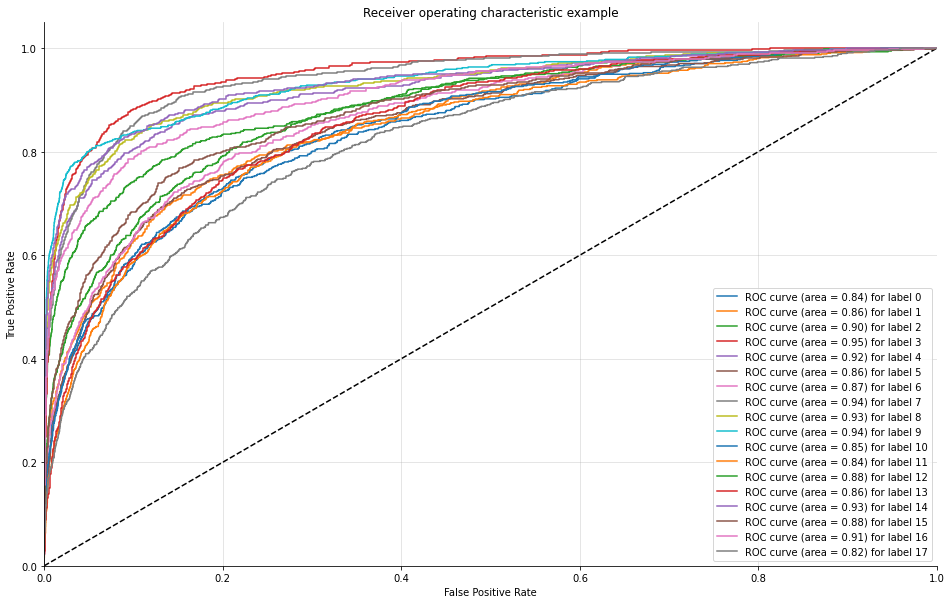

In [74]:
plot_multiclass_roc(lsvc, x_test, y_test, n_classes=18, figsize=(16, 10))

C:\Users\midom\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


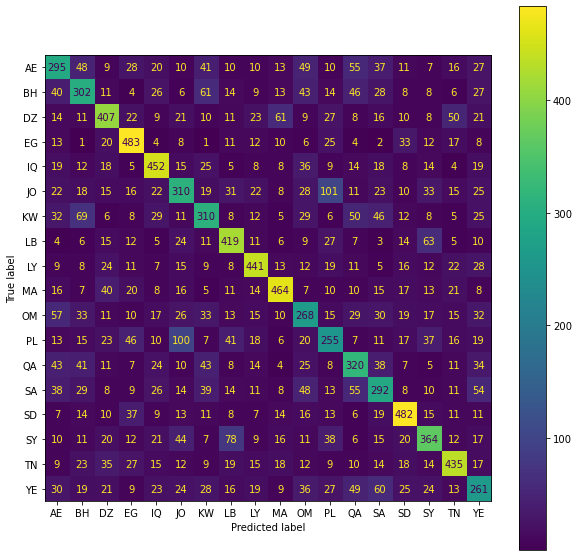

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(lsvc, x_val, y_val, ax=ax)  

# conclusion

it seems that the model with balanced data is slightly better in f1-score, but on the other hand we lost a lot of important data 